In [1]:
'''
This assignment centers around comparing the performance of three models: A model generated from scratch by following the 
Expedia challenge rules (one base and one improved will be compared), and two standard classification models. 
#Both will predict which hotel cluster would be the best to recommend users of Expedia based on their search 
#specifications on the site. All three will use a split training and testing dataset for training and testing to
#obtain precision as a scoring metric. All the models will have precision calculated, and these precision values 
#compared to determine which is a better predictor of hotel clusters for a search, the code written for the 
#Expedia challenge or the machine learning models.
'''

'''
Before the models are constructed, exploratory data analysis will be conducted to 
better understand how to predict the hotel cluster a user is likely to select.
'''

#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import operator
import ml_metrics as metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the data
#The train.csv file is much too large to be imported, so a chunk of it will be imported instead.
train = pd.read_csv('train.csv', iterator = True).get_chunk(1000000)
destinations = pd.read_csv('destinations.csv')

In [3]:
#Viewing the head of each dataset
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [4]:
destinations.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [5]:
#Shape of the data
print(train.shape)
print(destinations.shape)

(1000000, 24)
(62106, 150)


In [6]:
#Checking how many missing data values there are in each data frame
train.isnull().sum()

date_time                         0
site_name                         0
posa_continent                    0
user_location_country             0
user_location_region              0
user_location_city                0
orig_destination_distance    370247
user_id                           0
is_mobile                         0
is_package                        0
channel                           0
srch_ci                         998
srch_co                         999
srch_adults_cnt                   0
srch_children_cnt                 0
srch_rm_cnt                       0
srch_destination_id               0
srch_destination_type_id          0
is_booking                        0
cnt                               0
hotel_continent                   0
hotel_country                     0
hotel_market                      0
hotel_cluster                     0
dtype: int64

In [7]:
destinations.isnull().sum()

srch_destination_id    0
d1                     0
d2                     0
d3                     0
d4                     0
                      ..
d145                   0
d146                   0
d147                   0
d148                   0
d149                   0
Length: 150, dtype: int64

In [8]:
'''
The distance between each user and the destination could not always be calculated, resulting is several 
missing values for the orig_destination_distance column in the train.csv file. These will be filled in 
using the median distance.The destinations.csv file did not appear to contain any missing data. 
'''


train['orig_destination_distance'] = train['orig_destination_distance'].fillna(train['orig_destination_distance'].median())

In [9]:
#Rechecking the number of missing values
train.isnull().sum()

date_time                      0
site_name                      0
posa_continent                 0
user_location_country          0
user_location_region           0
user_location_city             0
orig_destination_distance      0
user_id                        0
is_mobile                      0
is_package                     0
channel                        0
srch_ci                      998
srch_co                      999
srch_adults_cnt                0
srch_children_cnt              0
srch_rm_cnt                    0
srch_destination_id            0
srch_destination_type_id       0
is_booking                     0
cnt                            0
hotel_continent                0
hotel_country                  0
hotel_market                   0
hotel_cluster                  0
dtype: int64

In [10]:
#The only missing data left now are in the check-in and check-out date columns. Since the number of missing data is very
#small compared to the overall length of the data frame (0.1%), the missing data of those columns can be removed.

train = train.dropna(axis = 0)
train.isnull().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

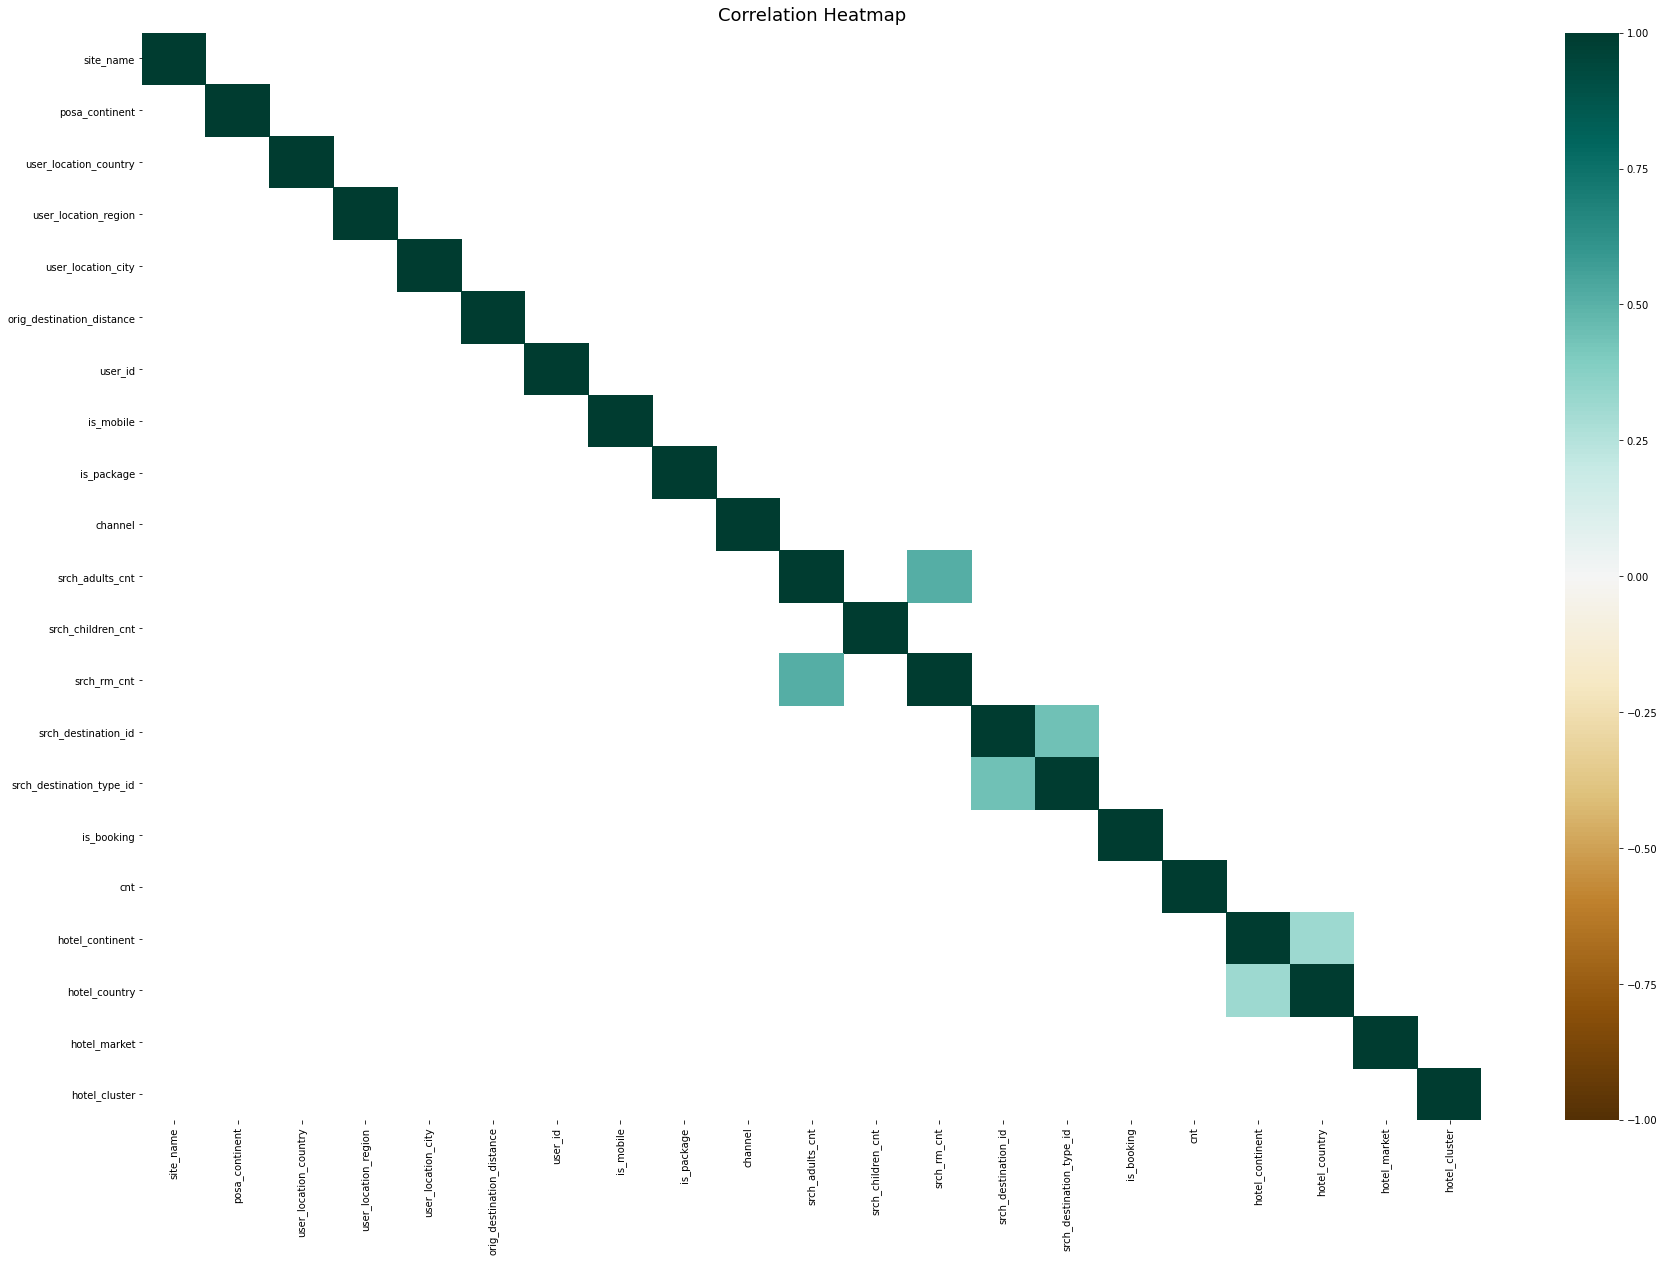

In [11]:
#Are there are variables that are correlated with each other within train.csv? 
#A heatmap will be constructed and variables that are correlated with a correlation 
#coefficient of >0.3 will be removed. 

#Correlations of train.csv
plt.figure(figsize = (30, 20))
heatmap = sns.heatmap(train.corr()[train.corr() >= 0.3], vmin = -1, vmax = 1, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize' : 18}, pad = 12);

,0,1,2,3,4,srch_destination_id
0,-0.044268,0.169419,0.032522,-0.014264,-0.069654,0
1,-0.440761,0.077405,-0.091572,-0.020208,0.013205,1
2,0.001033,0.020677,0.012109,0.134141,0.142006,2
3,-0.480467,-0.040345,-0.019320,-0.040105,-0.027384,3
4,-0.207253,-0.042694,-0.011744,-0.017541,-0.019856,4


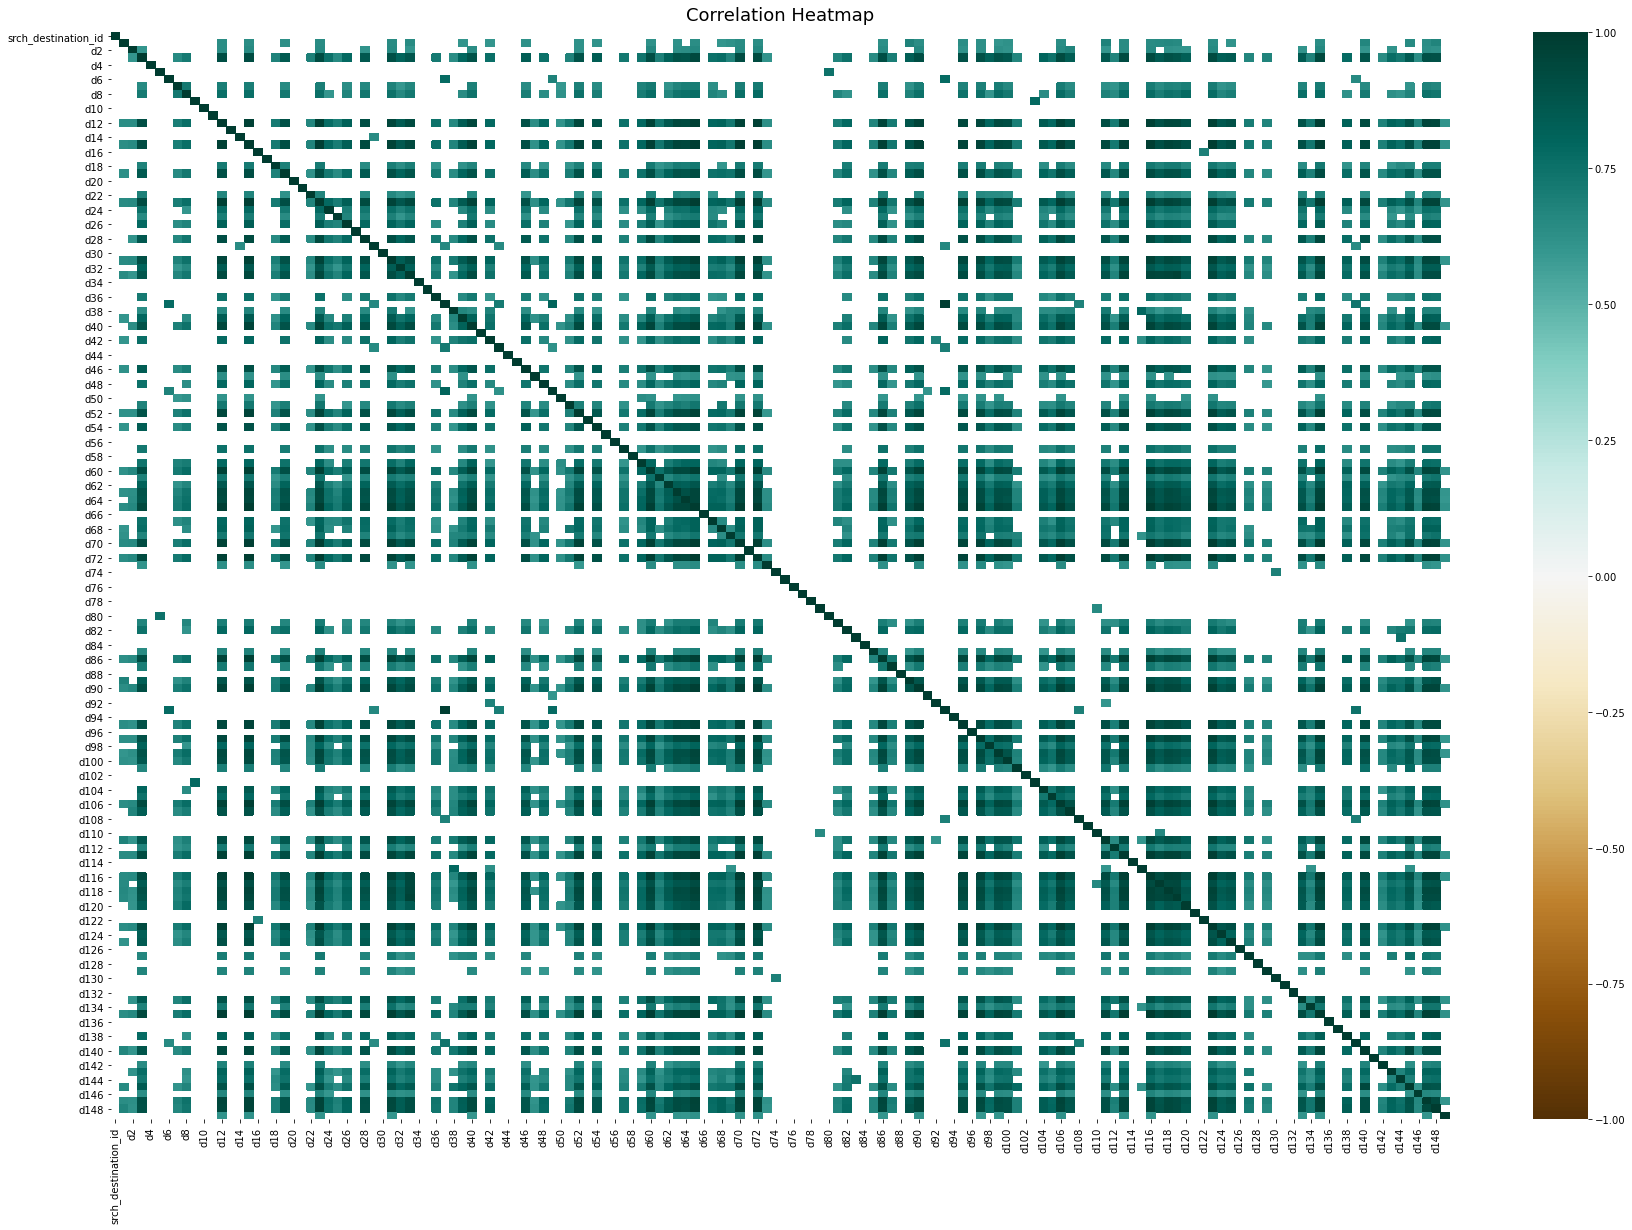

In [12]:
#Correlations of destinations.csv, this time using a cutoff of 0.5 for the correlation coefficient 
plt.figure(figsize = (30, 20))
heatmap = sns.heatmap(destinations.corr()[destinations.corr() >= 0.6], vmin = -1, vmax = 1, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize' : 18}, pad = 12);

#The correlations are all over the place. This makes sense, as destinations.csv is derived from text reviews.
#We want to reduce the number of features to only the few columns required for the model building, so PCA
#will be used to reduce the data down to 5 key columns. The correlation heatmap after PCA should look much clearer.

#Initiailizing the PCA, then fitting the PCA to the destination data and storing the columns in a new data frame
pca = PCA(n_components = 5)

#Getting the column name list
col_name_list = []
for x in range(1, 150):
    col_name_list.append('d{}'.format(x))

#Fitting the PCA to the destination data and storing the columns in a new data frame
shaved_set = pca.fit_transform(destinations[col_name_list])
shaved_set = pd.DataFrame(shaved_set)
shaved_set["srch_destination_id"] = destinations["srch_destination_id"]
shaved_set.head()

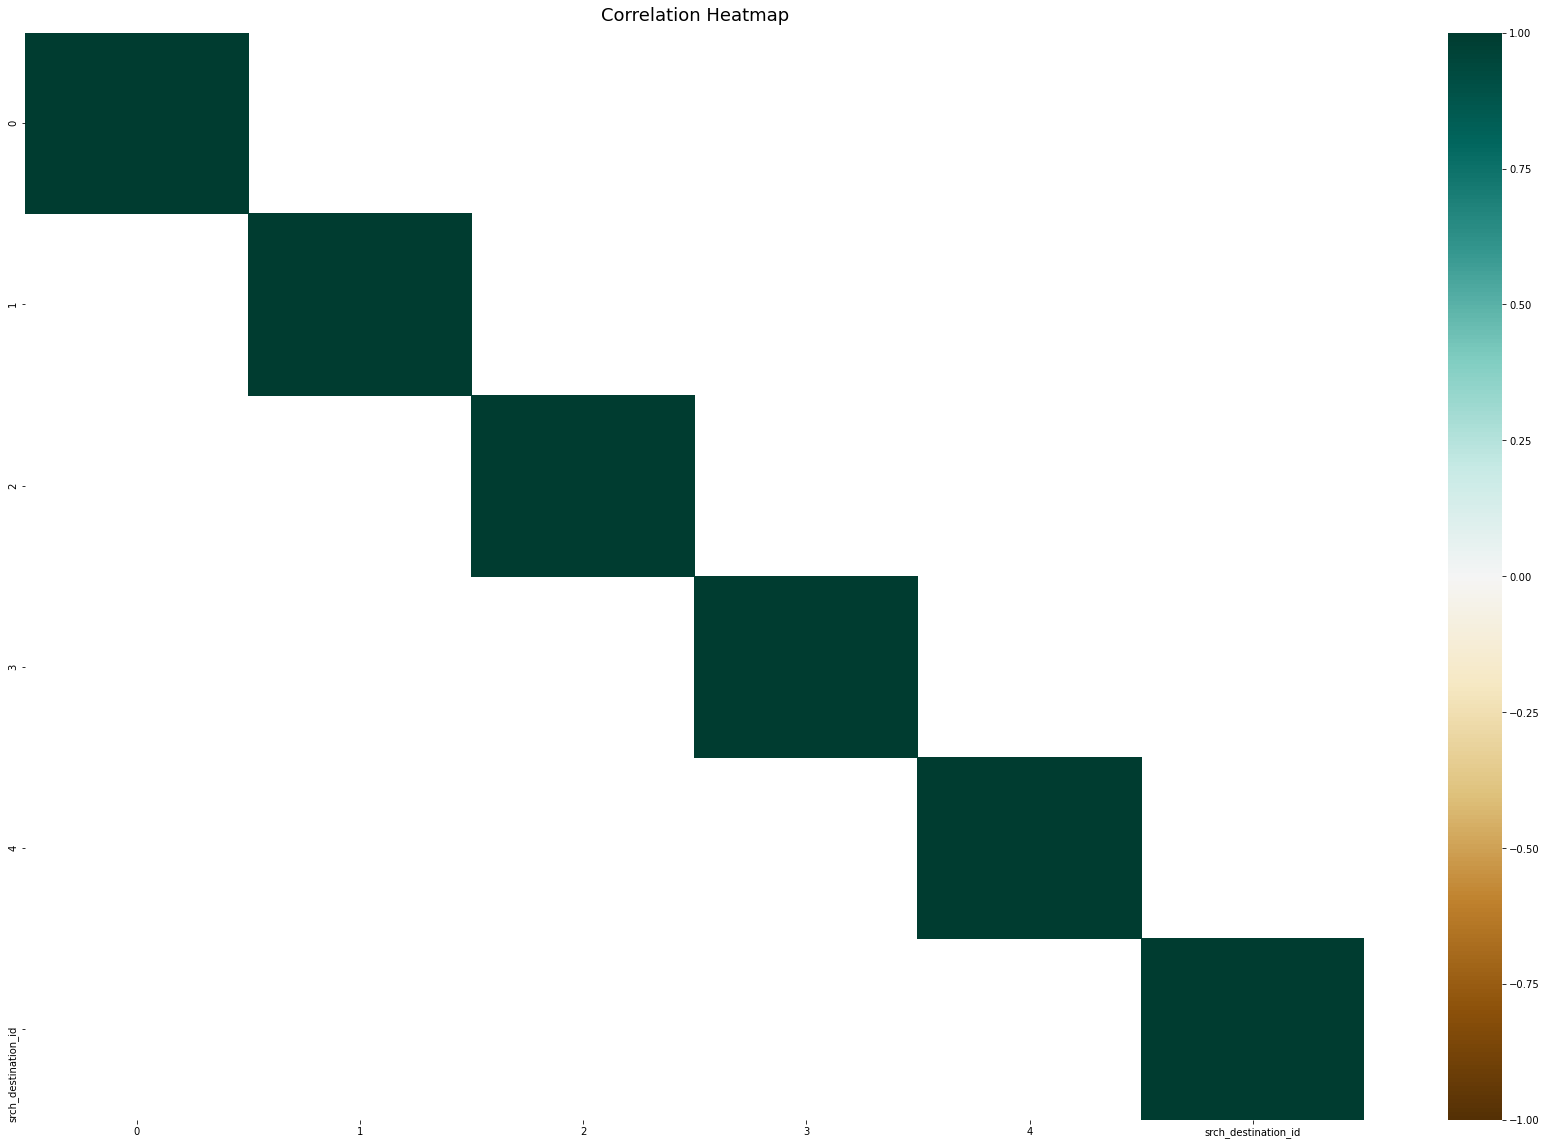

In [13]:
#Viewing a heatmap of the reduced dataset
plt.figure(figsize = (30, 20))
heatmap = sns.heatmap(shaved_set.corr()[shaved_set.corr() >= 0.5], vmin = -1, vmax = 1, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize' : 18}, pad = 12);

#We can see this dataset looks much cleaner, so it is ready to be used to build our models.

In [14]:
#Hotel country and continent are correlated, so continent will be removed, as continent is already given by country. Room
#count and adult count are correlated, so room count will be removed, as the number of adults plus number of children 
#provides more information than the number of rooms.

del train['hotel_continent']
del train['srch_rm_cnt']

#Checkout time will also be removed, as hotel customers consider checkin time much more heavily than checkout time
#when choosing a hotel (hotels get more expensive based on what time the checkin time is placed).

del train['srch_co']

In [15]:
#Merging the two datasets together and viewing the head
newtrain = train.merge(shaved_set, on = 'srch_destination_id')
newtrain.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_booking,cnt,hotel_country,hotel_market,hotel_cluster,0,1,2,3,4
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,3,50,628,1,2.168369,-0.061117,0.723258,-0.255067,0.258606
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1,1,50,628,1,2.168369,-0.061117,0.723258,-0.255067,0.258606
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,50,628,1,2.168369,-0.061117,0.723258,-0.255067,0.258606
3,2014-11-10 12:38:02,2,3,66,318,48382,1753.2617,776,0,1,...,0,1,50,628,24,2.168369,-0.061117,0.723258,-0.255067,0.258606
4,2014-04-29 16:32:53,2,3,66,174,16634,382.6993,3313,0,1,...,0,1,50,628,45,2.168369,-0.061117,0.723258,-0.255067,0.258606


In [16]:
#Shape of the merged data frame
print('Shape of the merged data frame: {}'.format(newtrain.shape))

Shape of the merged data frame: (994063, 26)


In [17]:
#Seeing how many uninque users are searching for hotels
newtrain['user_id'].nunique()

32753

In [18]:
#32753 users are responsible for 1000000 searches on the website. Let's see if the
#searches are spread out evenly by viewing the number of searches for each user.

user_search = newtrain.groupby(newtrain['user_id']).count()['hotel_cluster']
user_search.describe()
#It appears that 75% of users have below 34 searches, close to the mean value, but 25% of users are very active
#on the site, performing 34 to 495 searches each.

count    32753.000000
mean        30.350289
std         43.773520
min          1.000000
25%          6.000000
50%         14.000000
75%         34.000000
max        495.000000
Name: hotel_cluster, dtype: float64

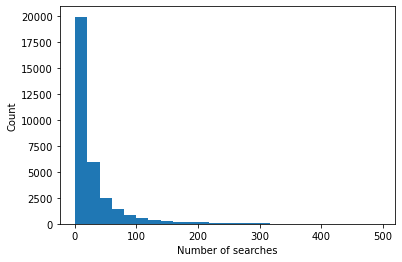

In [19]:
#Histogram of the above information

plt.hist(user_search, bins = 25)
plt.xlabel('Number of searches')
plt.ylabel('Count')
plt.show()

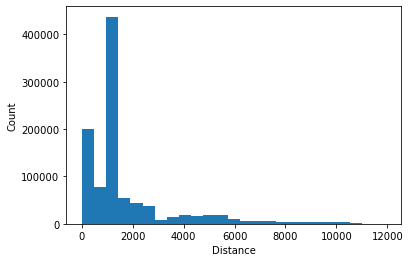

In [20]:
#Plotting a few histograms of numerical features

#Plotting histogram of destination distance from user to see how far most users are
plt.hist(newtrain['orig_destination_distance'], bins = 25)
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

#Most users appear to be within 2000 distance units of their destination.

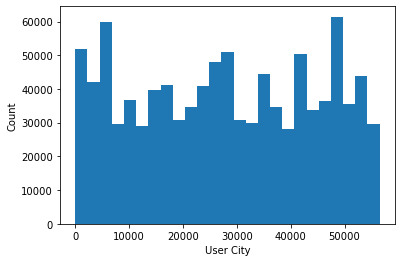

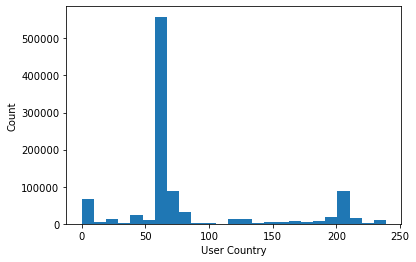

In [21]:
#Where are users located? Viewing histograms of city and country

plt.hist(newtrain['user_location_city'], bins = 25)
plt.xlabel('User City')
plt.ylabel('Count')
plt.show()

plt.hist(newtrain['user_location_country'], bins = 25)
plt.xlabel('User Country')
plt.ylabel('Count')
plt.show()

In [22]:
#Many users are from the same cities, but there is one country that stands out. Let's see what it is.

newtrain['user_location_country'].mode().values[0]

#Country number 66 is the country with the most Expedia users.

66

In [23]:
#The datetime column won't be useful for our analysis so it will be dropped

newtrain = newtrain.drop(['date_time', 'srch_ci'], axis = 1)

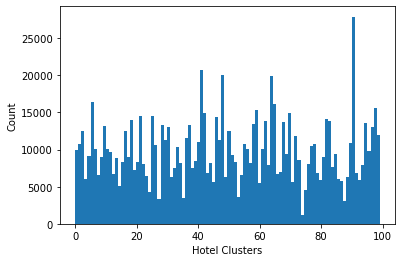

In [24]:
#Viewing the distribution of selected hotel clusters to see which ones are more popular

plt.hist(newtrain['hotel_cluster'], bins = 100)
plt.xlabel('Hotel Clusters')
plt.ylabel('Count')
plt.show()

In [25]:
#Based on the EDA, it looks like user's country, number of adults in the search, 
#and the destination type are good predictors for the hotel cluster the user is likely to select.

#Defining the features and target vector for our machine learning models
features = newtrain.iloc[:, newtrain.columns != 'hotel_cluster']
target = newtrain['hotel_cluster']
print('Features shape: {}'.format(features.shape))
print('Target vector shape: {}'.format(target.shape))

Features shape: (994063, 23)
Target vector shape: (994063,)


In [26]:
#Randomly sampling 10% of the dataframe so the model doesn't take a very long time to run
newtrain = newtrain.sample(frac = 0.1)

In [27]:
#Splitting the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

In [28]:
#Now I will write code for the Expedia challenge, predicting hotel clusters based on search data

#Splitting into training and testing data frames for use in this code
traindf, testdf = train_test_split(newtrain, test_size = 0.2, random_state = 42)

'''
Base model from scratch without any modification
Finding the top 5 most common clusters in the training dataset
'''

common_clusters = traindf['hotel_cluster'].value_counts()
common_clusters = list(common_clusters.head(5).index)

#Generating the predictions
pred_cluster = []
for x in range(testdf.shape[0]):
    pred_cluster.append(common_clusters)

#To use the MAPK function to evaluate mean average precision, the true clusters must be in list of lists format.
true_cluster = []
for x in testdf['hotel_cluster']:
    true_cluster.append([x])

#Evaluating the mean average precision for the model at k=5

print('Precision: {} percent'.format(metrics.mapk(true_cluster, pred_cluster, k = 5)*100))

'''
The precision is very low, only about 5 percent. However, it can be improved.
We can improve the score by finding the most popular clusters for each 
destination then comparing to the actual selected hotel clusters per destinaton 
in the testing dataset to obtain a precision score.
'''



Precision: 5.33975455185595 percent


'\nThe precision is very low, only about 5 percent. However, it can be improved.\nWe can improve the score by finding the most popular clusters for each \ndestination then comparing to the actual selected hotel clusters per destinaton \nin the testing dataset to obtain a precision score.\n'

In [29]:
#Improved model from scratch

#First, a funciton must be defined to convert into strings
def make_string(notstr):
    return "_".join([str(x) for x in notstr])

#Grouping the training set by destination then hotel cluster to get cluster groups for each destination
cluster_groups = traindf.groupby(['srch_destination_id', 'hotel_cluster'])

'''
Generating a dictionary of the clusters for each destination ordered by their popularity
Popularity here will be measured by whether a selected hotel cluster resulted in a booking,
so the number of bookings for each cluster in a group will be calculated to order them.
'''
most_popular_clusters_per_destination = {}
for name, group in cluster_groups:
    
    #Calculating the cluster popularity by seeing which clusters get booked more for each destination
    popularity = sum(group['is_booking'][group['is_booking'] == True])
    
    #Converting each cluster name in a group into a string
    cluster_string = make_string(name[:len(['srch_destination_id'])])
    
    #Initializing a dictionary for each destination and filling it with the cluster groups ordered by the 
    #popularity score calculated for each cluster above. This dictionary will then be placed as a value into a 
    #larger dictionary with destination IDs as the keys. This will result in a dictionary with destinations
    #as keys and the clusters as a dictionary themselves, which will then be converted into a list.
    if cluster_string not in most_popular_clusters_per_destination:
        most_popular_clusters_per_destination[cluster_string] = {}
    most_popular_clusters_per_destination[cluster_string][name[-1]] = popularity
    

In [30]:
#Storing the top 5 clusters for each destination in a list
cluster_dict = {}
for key in most_popular_clusters_per_destination:
    
    '''
    For every destination, the most popular clusters will be placed into a list, which will 
    be added as the values of a new dictionary. This essentially converts the previous dictionary
    from a dictionary containing dictionaries, into a dictionary containing lists instead.
    '''
    ordered = []
    for x in sorted(most_popular_clusters_per_destination[key].items(), key = operator.itemgetter(1), reverse=True)[:5]:
        ordered.append(x[0]) 
    cluster_dict[key] = ordered

In [31]:
#Generating the predictions
predictions = []
for i, row in testdf.iterrows():
    
    #Getting the destination ID for each row in the test dataset. To match them to the dictionary of clusters,
    #the ID must be converted into a string of integers, but to convert to an integer, the ID must be a float.
    ID = str(int(float(make_string([row['srch_destination_id']]))))
    
    #To eliminate inaccuracies, the list of popular clusters from the previous dictionary will
    #only be included if the destination in the testing set is present in the training set as well.
    if ID in cluster_dict:
        predictions.append(cluster_dict[ID])
    else:
        predictions.append([])

In [32]:
#Once again, to use the MAPK function to evaluate mean average precision, the true clusters must be in list of lists format.
lst = []
for x in testdf['hotel_cluster']:
    lst.append([x])
precision = metrics.mapk(lst, predictions, k = 5)

print('Precision: {} percent'.format(round(precision, 3)*100))

#Precision here is about 20 percent a 4-fold improvement on the base model from scratch.

Precision: 19.0 percent


In [34]:
#Building and evaluating a default Naive Bayes model with precision as the scoring metric

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
nb_precision = round(precision_score(y_test, y_pred, average = 'weighted'), 3)*100
print('Precision: {} percent'.format(nb_precision))

#Precision is 3.3 percent using a machine learning model, a much lower value than what was obtained via the Expedia code.

Precision: 3.3000000000000003 percent


In [35]:
#Building and evaluating another machine learning model, a decision tree classifier 
#using AdaBoost, to attempt to confirm the results of the previos classifier.

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred2 = ada.predict(X_test)
ada_precision = round(precision_score(y_test, y_pred2, average = 'weighted'), 3)*100
print('Precision: {} percent'.format(  ada_precision ))

Precision: 1.9 percent


In [ ]:
'''
Precision is still low for the AdaBoost model as well, around 2 percent, confirming the machine learning results. Because 
two machine learning models output much lower precision scores, this means that machine learning alone is not enough 
to generate a good performing classification model. While the Expedia code did not output good precision either (20%), 
it was still 6 times higher than the highest percentage that could be achieved from machine learning, 3.3 percent.

Why is machine learning not as good at recommending hotels as the code written from scratch? Perhaps it is because there 
are much too many factors that go into whether a user ultimately chooses one hotel over the other. 
'''